In [177]:
import os
import pandas as pd
import numpy as np
import zipfile

In [178]:
data_path = f"Data"
raw_data = os.path.join(data_path, f"Raw Data")
preprocess_path = os.path.join(data_path, f"Preprocessed Data")
results_path = f"Results"

# FIPS

In [179]:
counties = pd.read_csv(os.path.join(preprocess_path, f"Selected_Counties.csv"))

In [180]:
counties.head()

,State,RUCC,Counties 1
0,CA,1,Los Angeles
1,CA,2,Kern
2,CA,3,Imperial
3,CA,4,Lake
4,CA,5,Humboldt


In [181]:
continuum_codes = pd.read_excel(os.path.join(raw_data, f"Ruralurbancontinuumcodes2023.xlsx"), sheet_name="Rural-urban Continuum Code 2023", dtype={'FIPS': str})

In [182]:
continuum_codes.head()

,FIPS,State,County_Name,Population_2020,RUCC_2023,Description
0,01001,AL,Autauga County,58805,2.0,"Metro - Counties in metro areas of 250,000 to ..."
1,01003,AL,Baldwin County,231767,3.0,Metro - Counties in metro areas of fewer than ...
2,01005,AL,Barbour County,25223,6.0,"Nonmetro - Urban population of 5,000 to 20,000..."
3,01007,AL,Bibb County,22293,1.0,Metro - Counties in metro areas of 1 million p...
4,01009,AL,Blount County,59134,1.0,Metro - Counties in metro areas of 1 million p...


In [183]:
results = []
for index1, row1 in counties.iterrows():
    state = row1['State']
    county_name = row1['Counties 1']
    if not pd.isna(county_name):
        continuum_codes_state = continuum_codes[continuum_codes['State'] == state]
        for index2, row2 in continuum_codes_state.iterrows():
            if county_name in row2['County_Name']:
                results.append({
                    'State': state,
                    'County': str(row2['County_Name']),
                    'RUCC': row2['RUCC_2023'],
                    'FIPS': row2['FIPS'],
                    'State Code': row2['FIPS'][:2],
                    'County Code': row2['FIPS'][2:]
                })
                continue
        
fips = pd.DataFrame(results)

In [184]:
fips.to_csv(os.path.join(preprocess_path, "FIPS.csv"), index=False)

In [185]:
fips.head()

,State,County,RUCC,FIPS,State Code,County Code
0,CA,Los Angeles County,1.0,06037,06,037
1,CA,Kern County,2.0,06029,06,029
2,CA,Imperial County,3.0,06025,06,025
3,CA,Lake County,4.0,06033,06,033
4,CA,Humboldt County,5.0,06023,06,023


# State, County Code

In [186]:
state_county_code = pd.read_excel(os.path.join(raw_data, f'2020_UA_COUNTY.xlsx'), sheet_name='2020_UA_COUNTY', dtype={'STATE': str, 'COUNTY': str})

In [187]:
state_county_code.head()

,STATE,COUNTY,STATE_NAME,COUNTY_NAME,POP_COU,HOU_COU,ALAND_COU,ALAND_Mi²_COU,POPDEN_COU,HOUDEN_COU,...,POP_RUR,POPPCT_RUR,HOU_RUR,HOUPCT_RUR,ALAND_RUR,ALAND_Mi²_RUR,ALAND_PCT_RUR,POPDEN_RUR,HOUDEN_RUR,RURALBLOCKS
0,01,001,Alabama,Autauga,58805,24350,1539634184,594.452758,98.922916,40.962044,...,23920,0.406768,9991,0.410308,1483727020,572.867002,0.963688,41.754892,17.440348,991
1,01,003,Alabama,Baldwin,231767,124148,4117656199,1589.827058,145.781265,78.088997,...,87113,0.375865,40740,0.328157,3762600021,1452.739868,0.913772,59.964624,28.043562,3181
2,01,005,Alabama,Barbour,25223,11618,2292160149,885.003034,28.500467,13.127639,...,16627,0.659200,7538,0.648821,2276027730,878.774307,0.992962,18.920672,8.577857,1011
3,01,007,Alabama,Bibb,22293,9002,1612188717,622.466064,35.814001,14.461833,...,22293,1.000000,9002,1.000000,1612188717,622.466064,1.000000,35.814001,14.461833,1090
4,01,009,Alabama,Blount,59134,24622,1670259090,644.887035,91.696680,38.180330,...,53510,0.904894,22337,0.907197,1658933117,640.514076,0.993219,83.542270,34.873551,2207


In [188]:
state_county_names = pd.merge(fips, state_county_code, left_on=['State Code', 'County Code'], right_on=['STATE', 'COUNTY'], how='inner')
state_county_names.rename(columns={'STATE_NAME': 'State Name', 'COUNTY_NAME': 'County Name', 'State': 'State Name Code', 'County': 'County Full Name'}, inplace=True)
state_county_names = state_county_names[['State Code', 'County Code', 'FIPS', 'State Name', 'County Name', 'RUCC', 'State Name Code', 'County Full Name']]

In [189]:
state_county_names.head()

,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name
0,06,037,06037,California,Los Angeles,1.0,CA,Los Angeles County
1,06,029,06029,California,Kern,2.0,CA,Kern County
2,06,025,06025,California,Imperial,3.0,CA,Imperial County
3,06,033,06033,California,Lake,4.0,CA,Lake County
4,06,023,06023,California,Humboldt,5.0,CA,Humboldt County


In [190]:
state_county_names.to_csv(os.path.join(preprocess_path, "state_county_names.csv"), index=False)

# Population Estimates

In [191]:
population_2018_2019_df = pd.read_csv(os.path.join(raw_data, "co-est2020-alldata.csv"), encoding = "ISO-8859-1", dtype={'STATE': str, 'COUNTY':str})
population_2018_2019_df_sub = population_2018_2019_df[['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2018', 'POPESTIMATE2019']].copy()
population_2018_2019_df_sub.rename(columns={'STNAME': 'State Name', 'CTYNAME': 'County Name', 'STATE': 'State Code', 'COUNTY': 'County Code'}, inplace=True)

In [192]:
population_2020_2023_df = pd.read_csv(os.path.join(raw_data, "co-est2023-alldata.csv"), encoding = "ISO-8859-1", dtype={'STATE': str, 'COUNTY':str})
population_2020_2023_df_sub = population_2020_2023_df[['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022', 'POPESTIMATE2023']].copy()
population_2020_2023_df_sub.rename(columns={'STNAME': 'State Name', 'CTYNAME': 'County Name', 'STATE': 'State Code', 'COUNTY': 'County Code'}, inplace=True)

In [193]:
population_2018_2023_df = pd.merge(population_2018_2019_df_sub, population_2020_2023_df_sub, left_on=['State Code', 'County Code'], right_on=['State Code', 'County Code'], how='inner')
population_2018_2023_df.rename(columns={'State Name_x': 'State Name', 'County Name_x': 'County Name'}, inplace=True)
population_2018_2023_df_sub = population_2018_2023_df[['State Code', 'County Code', 'State Name', 'County Name', 'POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022', 'POPESTIMATE2023']]

In [194]:
population_2018_2023_df_sub.head()

,State Code,County Code,State Name,County Name,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023
0,01,000,Alabama,Alabama,4891628,4907965,5031864,5050380,5073903,5108468
1,01,001,Alabama,Autauga County,55533,55769,58915,59203,59726,60342
2,01,003,Alabama,Baldwin County,218071,223565,233227,239439,246531,253507
3,01,005,Alabama,Barbour County,24887,24657,24969,24533,24700,24585
4,01,007,Alabama,Bibb County,22300,22313,22188,22359,21986,21868


In [195]:
#oh that's great code
population_stacked = population_2018_2023_df_sub.melt(id_vars=['State Code', 'County Code', 'State Name', 'County Name'],
                    value_vars=['POPESTIMATE2018', 'POPESTIMATE2019', 'POPESTIMATE2020', 
                                'POPESTIMATE2021', 'POPESTIMATE2022', 'POPESTIMATE2023'],
                    var_name='Year', value_name='Population')

# Extracting the year from the 'Year' column
population_stacked['Year'] = population_stacked['Year'].str.extract(r'(\d{4})').astype(int)

In [196]:
population_sub = pd.merge(population_stacked, state_county_names, left_on=['State Code', 'County Code'], right_on=['State Code', 'County Code'], how='inner')
population_sub.rename(columns={'State Name_x': 'State Name', 'County Name_y': 'County Name'}, inplace=True)

In [197]:
population_sub.head()

,State Code,County Code,State Name,County Name_x,Year,Population,FIPS,State Name_y,County Name,RUCC,State Name Code,County Full Name
0,06,021,California,Glenn County,2018,27899,06021,California,Glenn,6.0,CA,Glenn County
1,06,023,California,Humboldt County,2018,136502,06023,California,Humboldt,5.0,CA,Humboldt County
2,06,025,California,Imperial County,2018,181062,06025,California,Imperial,3.0,CA,Imperial County
3,06,029,California,Kern County,2018,893618,06029,California,Kern,2.0,CA,Kern County
4,06,033,California,Lake County,2018,64394,06033,California,Lake,4.0,CA,Lake County


In [198]:
population_df = population_sub[['State Code', 'County Code', 'FIPS', 'State Name', 'County Name', 'RUCC', 'State Name Code', 'County Full Name', 'Year', 'Population']].copy()

In [199]:
population_df.head()

,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name,Year,Population
0,06,021,06021,California,Glenn,6.0,CA,Glenn County,2018,27899
1,06,023,06023,California,Humboldt,5.0,CA,Humboldt County,2018,136502
2,06,025,06025,California,Imperial,3.0,CA,Imperial County,2018,181062
3,06,029,06029,California,Kern,2.0,CA,Kern County,2018,893618
4,06,033,06033,California,Lake,4.0,CA,Lake County,2018,64394


In [200]:
population_df.to_csv(os.path.join(preprocess_path, "population.csv"), index=False)

# Annual AQI Data

In [201]:
years = range(2018, 2024, 1)
zip_files = [f'annual_aqi_by_county_{year}' for year in years]

# Initialize an empty list to store dataframes
df_list = []

for year in years:
    zip_file_name = os.path.join(raw_data, f'annual_aqi_by_county_{year}.zip')

    with zipfile.ZipFile(zip_file_name, 'r') as z:
        csv_file = z.namelist()[0]
        with z.open(csv_file) as f:
            df = pd.read_csv(f)
            df_list.append(df)

merged_aqi = pd.concat(df_list, ignore_index=True)
merged_aqi.to_csv(os.path.join(preprocess_path, 'merged_aqi_by_county_2018_2023.csv'), index=False)

In [202]:
merged_aqi_pops = pd.merge(merged_aqi, population_df, left_on=['State', 'County', 'Year'], right_on=['State Name', 'County Name', 'Year'], how='inner')

In [203]:
merged_aqi_pops.to_csv(os.path.join(preprocess_path, "merged_aqi_county.csv"), index=False)

In [204]:
merged_aqi_pops.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,Days PM10,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name,Population
0,California,Glenn,2018,363,275,72,9,6,1,0,...,73,06,021,06021,California,Glenn,6.0,CA,Glenn County,27899
1,California,Humboldt,2018,365,324,35,5,1,0,0,...,18,06,023,06023,California,Humboldt,5.0,CA,Humboldt County,136502
2,California,Imperial,2018,365,95,220,41,7,2,0,...,129,06,025,06025,California,Imperial,3.0,CA,Imperial County,181062
3,California,Kern,2018,365,65,170,103,27,0,0,...,13,06,029,06029,California,Kern,2.0,CA,Kern County,893618
4,California,Lake,2018,357,347,7,1,1,1,0,...,2,06,033,06033,California,Lake,4.0,CA,Lake County,64394


In [205]:
merged_aqi_pops.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10', 'State Code', 'County Code',
       'FIPS', 'State Name', 'County Name', 'RUCC', 'State Name Code',
       'County Full Name', 'Population'],
      dtype='object')

In [206]:
merged_aqi_pops.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,...,Days PM10,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name,Population
0,California,Glenn,2018,363,275,72,9,6,1,0,...,73,06,021,06021,California,Glenn,6.0,CA,Glenn County,27899
1,California,Humboldt,2018,365,324,35,5,1,0,0,...,18,06,023,06023,California,Humboldt,5.0,CA,Humboldt County,136502
2,California,Imperial,2018,365,95,220,41,7,2,0,...,129,06,025,06025,California,Imperial,3.0,CA,Imperial County,181062
3,California,Kern,2018,365,65,170,103,27,0,0,...,13,06,029,06029,California,Kern,2.0,CA,Kern County,893618
4,California,Lake,2018,357,347,7,1,1,1,0,...,2,06,033,06033,California,Lake,4.0,CA,Lake County,64394


In [207]:
aqi_data = merged_aqi_pops[['FIPS', 'State', 'County', 'State Code', 'County Code', 'Year', 'RUCC', 'Population', 'Max AQI', '90th Percentile AQI', 'Median AQI']]

In [208]:
aqi_data.head()

,FIPS,State,County,State Code,County Code,Year,RUCC,Population,Max AQI,90th Percentile AQI,Median AQI
0,06021,California,Glenn,06,021,2018,6.0,27899,230,69,36
1,06023,California,Humboldt,06,023,2018,5.0,136502,163,53,34
2,06025,California,Imperial,06,025,2018,3.0,181062,286,108,62
3,06029,California,Kern,06,029,2018,2.0,893618,190,142,84
4,06033,California,Lake,06,033,2018,4.0,64394,208,43,33


In [209]:
aqi_data.to_csv(os.path.join(preprocess_path, "aqi_data.csv"), index=False)

In [210]:
aqi_data.shape

(133, 11)

# Pollutants Data

In [218]:
#CO
co_data_files = ["CO_2018_CA.csv", "CO_2018_NY.csv", "CO_2018_PA.csv", "CO_2018_TX.csv", 
                 "CO_2019_CA.csv", "CO_2019_NY.csv", "CO_2019_PA.csv", "CO_2019_TX.csv", 
                 "CO_2020_CA.csv", "CO_2020_NY.csv", "CO_2020_PA.csv", "CO_2020_TX.csv", 
                 "CO_2021_CA.csv", "CO_2021_NY.csv", "CO_2021_PA.csv", "CO_2021_TX.csv",
                 "CO_2022_CA.csv", "CO_2022_NY.csv", "CO_2022_PA.csv", "CO_2022_TX.csv", 
                 "CO_2023_CA.csv", "CO_2023_NY.csv", "CO_2023_PA.csv", "CO_2023_TX.csv"]


In [219]:
dataframes = []
#years = ['2018', '2019', '2020', '2021', '2022', '2023']

for file in co_data_files:
    year = file.split('_')[1]
    df = pd.read_csv(os.path.join(raw_data, file))
    df['Year'] = year
    dataframes.append(df)

merged_df_co = pd.concat(dataframes, ignore_index=True)

# Save the combined DataFrame to a new CSV file
merged_df_co.to_csv(os.path.join(preprocess_path, "CO_2018_2023.csv"), index=False)

In [220]:
merged_df_co[merged_df_co.State == 'California']['County'].unique()

array(['Alameda', 'Butte', 'Contra Costa', 'Fresno', 'Humboldt',
       'Imperial', 'Inyo', 'Kern', 'Los Angeles', 'Madera', 'Marin',
       'Monterey', 'Napa', 'Orange', 'Riverside', 'Sacramento',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Mateo', 'Santa Barbara', 'Santa Clara', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter'], dtype=object)

In [221]:
filtered_df_co = pd.merge(merged_df_co, state_county_names, left_on=['State', 'County'], right_on=['State Name', 'County Name'], how='inner')
filtered_df_co = filtered_df_co[['Date','Year', 'Source', 'Site ID', 'Daily Max 8-hour CO Concentration', 'Units', 'Daily AQI Value', 'State Code', 'County Code', 'FIPS', 'State Name', 'County Name', 'RUCC', 'State Name Code', 'County Full Name']]
filtered_df_co.head()

,Date,Year,Source,Site ID,Daily Max 8-hour CO Concentration,Units,Daily AQI Value,State Code,County Code,FIPS,State Name,County Name,RUCC,State Name Code,County Full Name
0,01/01/2018,2018,AQS,60231004,0.4,ppm,5,06,023,06023,California,Humboldt,5.0,CA,Humboldt County
1,01/02/2018,2018,AQS,60231004,0.6,ppm,7,06,023,06023,California,Humboldt,5.0,CA,Humboldt County
2,01/03/2018,2018,AQS,60231004,0.7,ppm,8,06,023,06023,California,Humboldt,5.0,CA,Humboldt County
3,01/04/2018,2018,AQS,60231004,0.3,ppm,3,06,023,06023,California,Humboldt,5.0,CA,Humboldt County
4,01/05/2018,2018,AQS,60231004,0.2,ppm,2,06,023,06023,California,Humboldt,5.0,CA,Humboldt County


In [222]:
filtered_df_co['Date'] = pd.to_datetime(filtered_df_co['Date'], format='%m/%d/%Y')

# Filter for the specific year if needed (e.g., 2020)
#filtered_df_so2_2020 = filtered_df_so2[filtered_df_so2['Date'].dt.year == 2020]

# Group by State Name and County Name, then calculate the mean of Daily Max 1-hour SO2 Concentration
mean_concentration_co = filtered_df_co.groupby(['Year', 'State Name', 'County Name', 'County Code', 'State Code', 'RUCC', 'FIPS'])['Daily Max 8-hour CO Concentration'].mean().reset_index()

# Rename the column for clarity
mean_concentration_co.rename(columns={'Daily Max 8-hour CO Concentration': 'Mean Daily Max 8-hour CO Concentration'}, inplace=True)
#merged_df_so2 = pd.merge(filtered_df_so2, mean_concentration_so2, on=['State Name', 'County Name'], suffixes=('', '_Mean'))

#final_df_so2 = merged_df_so2.drop_duplicates(subset=['State Name', 'County Name'])
# Display the result
mean_concentration_co

,Year,State Name,County Name,County Code,State Code,RUCC,FIPS,Mean Daily Max 8-hour CO Concentration
0,2018,California,Humboldt,023,06,5.0,06023,0.232778
1,2018,California,Imperial,025,06,3.0,06025,0.604558
2,2018,California,Kern,029,06,2.0,06029,0.291220
3,2018,California,Los Angeles,037,06,1.0,06037,0.499778
4,2018,Texas,Dallas,113,48,1.0,48113,0.304559
5,2019,California,Humboldt,023,06,5.0,06023,0.285515
6,2019,California,Imperial,025,06,3.0,06025,0.443836
7,2019,California,Kern,029,06,2.0,06029,0.326648
8,2019,California,Los Angeles,037,06,1.0,06037,0.475232
9,2019,Texas,Dallas,113,48,1.0,48113,0.273464


In [223]:
final_df_co = pd.merge(mean_concentration_co, population_df, on=['State Code', 'County Code', 'State Name', 'County Name', 'RUCC', 'FIPS'])
final_df_co

,Year_x,State Name,County Name,County Code,State Code,RUCC,FIPS,Mean Daily Max 8-hour CO Concentration,State Name Code,County Full Name,Year_y,Population
0,2018,California,Humboldt,023,06,5.0,06023,0.232778,CA,Humboldt County,2018,136502
1,2018,California,Humboldt,023,06,5.0,06023,0.232778,CA,Humboldt County,2019,135839
2,2018,California,Humboldt,023,06,5.0,06023,0.232778,CA,Humboldt County,2020,136262
3,2018,California,Humboldt,023,06,5.0,06023,0.232778,CA,Humboldt County,2021,134897
4,2018,California,Humboldt,023,06,5.0,06023,0.232778,CA,Humboldt County,2022,134944
...,...,...,...,...,...,...,...,...,...,...,...,...
175,2023,Texas,Dallas,113,48,1.0,48113,0.302466,TX,Dallas County,2019,2635603
176,2023,Texas,Dallas,113,48,1.0,48113,0.302466,TX,Dallas County,2020,2610112
177,2023,Texas,Dallas,113,48,1.0,48113,0.302466,TX,Dallas County,2021,2588235
178,2023,Texas,Dallas,113,48,1.0,48113,0.302466,TX,Dallas County,2022,2601993


## Statewise Correlation Per Year (PPM)

In [217]:
grouped_df = final_df_co.groupby(['State Name', 'Year'])

# Calculate the correlation for each group
correlation_results = {}
for (state, year), group in grouped_df:
    correlation = group['Mean Daily Max 8-hour CO Concentration'].corr(group[f'POPESTIMATE{year}'])
    correlation_results[(state, year)] = correlation

# Convert the results dictionary to a DataFrame
correlation_df_co = pd.DataFrame(list(correlation_results.items()), columns=['State_Year', 'Correlation'])
correlation_df_co[['State Name', 'Year']] = pd.DataFrame(correlation_df_co['State_Year'].tolist(), index=correlation_df_co.index)
correlation_df_co.drop(columns=['State_Year'], inplace=True)

KeyError: 'Year'

# Emissions Data

In [167]:
mobility_trends = pd.read_csv(os.path.join(raw_data, "Mobility_Trends_County_Modeling_Dataset.csv"), dtype={'state_code': str, 'county_code': str}, encoding = "ISO-8859-1")

In [168]:
mobility_trends.head()

,full_fips_code,year,state_code,county_code,fipsyear,vmt,population,total_emissions,true_gdp,unemployment_rate,...,capital_transit_funding,vmt_log_predictions,vmt_predictions,logvmt,total_emissions_log_predictions,total_emissions_predictions,logtotal_emissions,transit_user_count_log_predictions,transit_user_count_predictions,logtransit_user_count
0,1001,2000,1,1,01001-2000,274449272.4,44021.0,NaN,NaN,0.041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,2001,1,1,01001-2001,294383486.5,44889.0,NaN,949800.0,0.041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,2002,1,1,01001-2002,302790677.5,45909.0,NaN,984039.0,0.048,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,2003,1,1,01001-2003,308238612.8,46800.0,NaN,1008032.0,0.050,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001,2004,1,1,01001-2004,321675555.3,48366.0,NaN,1170278.0,0.047,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
# Renaming columns in mobility_trends to match merged_aqi_pops 
mobility_trends = mobility_trends.rename(columns={
    'state_code': 'State Code',
    'county_code': 'County Code',
    'year': 'Year'
})

# Merging the dataframes on State code, County code, and Year
merged_df = pd.merge(aqi_data, mobility_trends, on=['State Code', 'County Code', 'Year'])

# Selecting the required columns
final_columns = ['State', 'County', 'Year', 'RUCC', 'Max AQI', 'Median AQI', 'vmt', 'vmt_per_person', 'tms', 'Population','population',
                 'total_emissions', 'pop_density', 'warehouse_emply', 'courier_emply']
merged_mobility = merged_df[final_columns]

In [170]:
merged_mobility.head()

,State,County,Year,RUCC,Max AQI,Median AQI,vmt,vmt_per_person,tms,Population,population,total_emissions,pop_density,warehouse_emply,courier_emply
0,Nebraska,Sarpy,2018,2.0,93,35,5.698874e+08,3096.170910,0.005963,184106,184062.0,NaN,772.876146,1418.0,169.0
1,Pennsylvania,Somerset,2018,6.0,90,33,4.687403e+08,6345.304435,0.003157,73951,73872.0,NaN,68.758755,NaN,NaN
2,Pennsylvania,Tioga,2018,8.0,97,35,6.991904e+07,1718.334603,0.000000,40725,40690.0,NaN,35.889018,NaN,NaN
3,Texas,Dallas,2018,1.0,161,44,1.182662e+10,4497.926595,0.026978,2629764,2629350.0,NaN,3015.116002,21587.0,13009.0
4,Texas,Hood,2018,4.0,133,33,1.810618e+08,3008.821337,0.002651,60249,60177.0,NaN,143.038811,NaN,NaN


In [171]:
mobility_trends.columns

Index(['full_fips_code', 'Year', 'State Code', 'County Code', 'fipsyear',
       'vmt', 'population', 'total_emissions', 'true_gdp', 'unemployment_rate',
       'charging_stations', 'lnmiles', 'tms', 'telework', 'aland_sqmi',
       'warehouse_emply', 'courier_emply', 'courier_wages',
       'courier_nonemp_estab', 'courier_nonemp_rcptot', 'cpi',
       'courier_nonemp_rcptot_real', 'driver_nonemp_estab',
       'driver_nonemp_rcptot', 'driver_nonemp_rcptot_real', 'pop_density',
       'upt_distr_commuters', 'transit_user_count', 'vmt_per_person',
       'gdp_per_person', 'charging_stations_per_person', 'lnmiles_per_person',
       'upt_per_person', 'county_type', 'internet_connections', 'unemployed',
       'labor_force', 'teleworkers', 'capital_transit_funding',
       'vmt_log_predictions', 'vmt_predictions', 'logvmt',
       'total_emissions_log_predictions', 'total_emissions_predictions',
       'logtotal_emissions', 'transit_user_count_log_predictions',
       'transit_user_count

In [172]:
merged_mobility.to_csv(os.path.join(preprocess_path, "merged_pop_mobility.csv"), index=False)

           State  Year  Population  Max AQI  RUCC           vmt
0       Nebraska  2018      184106       93   2.0  5.698874e+08
1   Pennsylvania  2018       73951       90   6.0  4.687403e+08
2   Pennsylvania  2018       40725       97   8.0  6.991904e+07
3          Texas  2018     2629764      161   1.0  1.182662e+10
4          Texas  2018       60249      133   4.0  1.810618e+08
5          Texas  2018       57970      100   3.0  2.553028e+08
6       Nebraska  2019      186893       80   2.0  5.667939e+08
7   Pennsylvania  2019       73442       80   6.0  4.727597e+08
8   Pennsylvania  2019       40665       74   8.0  7.566593e+07
9          Texas  2019     2635603      143   1.0  1.152345e+10
10         Texas  2019       61762      133   4.0  1.833771e+08
11         Texas  2019       58357      104   3.0  2.594855e+08
12      Nebraska  2020      191167      149   2.0  4.844889e+08
13  Pennsylvania  2020       74019       71   6.0  4.043746e+08
14  Pennsylvania  2020       41025      

C:\Users\aathi\anaconda3\envs\ke\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\aathi\anaconda3\envs\ke\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


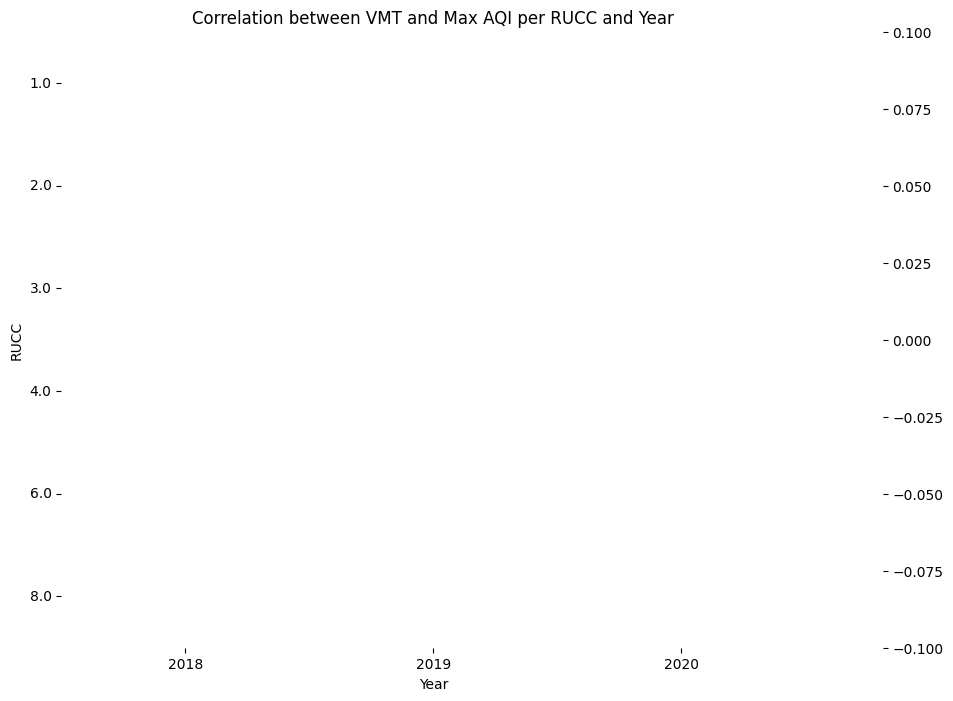

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Including RUCC in the filtered data
relevant_columns = ['State', 'Year', 'Population', 'Max AQI', 'RUCC', 'vmt']
data_filtered = merged_mobility[relevant_columns]

# Excluding RUCC 5 and 9 from the filtered data
data_filtered = data_filtered[~data_filtered['RUCC'].isin(['5.0', '9.0'])]
print(data_filtered)
# Grouping by RUCC and Year, and then calculating the correlation between industrial activity (vmt here) and Max AQI
correlation_data_rucc = data_filtered.groupby(['RUCC', 'Year']).corr(numeric_only=True).reset_index()

# Extracting only the correlations of interest
correlation_data_rucc = correlation_data_rucc[correlation_data_rucc['level_2'] == 'vmt'][['RUCC', 'Year', 'Max AQI']]

# Pivoting the dataframe for heatmap
heatmap_data_rucc = correlation_data_rucc.pivot(index="RUCC", columns="Year", values="Max AQI")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_rucc, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation between VMT and Max AQI per RUCC and Year')
plt.yticks(rotation=0)
plt.show()

# RDF Conversion

In [102]:
merged_mobility.columns

Index(['State', 'County', 'Year', 'RUCC', 'Max AQI', 'Median AQI', 'vmt',
       'vmt_per_person', 'tms', 'Population', 'population', 'total_emissions',
       'pop_density', 'warehouse_emply', 'courier_emply'],
      dtype='object')

In [103]:
print(aqi_data.shape)
print(merged_mobility.shape)

(133, 11)
(18, 15)


In [175]:
''' Subject: <County_URI> 
Predictes and Objects: 
1. hasState: State name
2. hasRUCC: RUCC
3. hasPopulation: Population Estimate
4. hasMedianAQI: Median AQI
 '''
from rdflib import Graph, Literal, RDF, URIRef, Namespace

EX = Namespace("ke#")
g = Graph()

for index, row in merged_mobility.iterrows():
    county_year = EX[f"{row['County'].replace(' ', '_')}_{row['Year']}"]
    state = EX[f"State#{row['State'].replace(' ', '_')}"]
    county = EX[f"County#{row['County'].replace(' ', '_')}"]
    
    rucc = EX[f"RUCC#{row['RUCC']}"]
    population = EX[f"Population#{row['Population']}"]
    aqi = EX[f"MedianAQI#{row['Median AQI']}"]

    vmt = EX[f"VMT#{row['vmt']}"]
    # total_emissions = EX[f"TotalEmissions#{row['total_emissions']}"]

    g.add((state, EX.hasState, county))
    g.add((county_year, EX.hasCounty, county))
    g.add((county, EX.hasRUCC, rucc))
    g.add((county_year, EX.hasPopulation, population))
    g.add((county_year, EX.hasMedianAQI, aqi))
    g.add((county_year, EX.hasVMT, vmt))
    # g.add((county_year, EX.hasTotalEmissions, total_emissions))

# Serialize the RDF graph to Turtle format
# print(g.serialize(format='turtle'))

In [176]:
from pyvis.network import Network
net = Network(height='750px', width='100%', directed=False, neighborhood_highlight=True)

# Add nodes and edges to the network
for subject, predicate, object in g:
    subject_label = str(subject).split("#")[-1]
    predicate_label = str(predicate).split("#")[-1]
    object_label = str(object).split("#")[-1]

    subject_type = str(subject).split("#")[-2]
    predicate_type = str(predicate).split("#")[-2]
    object_type = str(object).split("#")[-2]

    
        
    if subject_label not in net.node_ids:
        if "ke" in subject_type:
            subject_title = subject_label
        else:
            subject_title = subject_type + ": " + subject_label
        net.add_node(subject_label, 
                     label=subject_label, 
                     title=subject_title, 
                     labelHighlightBold=True)
        
    if object_label not in net.node_ids:
        if "ke" in object_type:
            object_title = object_label
        else:
            object_title = object_type + ": " + object_label
            
        net.add_node(object_label, 
                     label=object_label, 
                     title=object_title, 
                     labelHighlightBold=True)

    edge_color = {
        'hasState': 'red',
        'hasCounty': 'orange',
        'hasPopulation': 'green',
        'hasMedianAQI': 'blue',
        'hasRUCC': 'black'
    }.get(predicate_label, 'grey')

    
    net.add_edge(subject_label, 
                     object_label, 
                     title=predicate_label, 
                     label=predicate_label, 
                     color=edge_color)
    
# # Show the network
net.save_graph(os.path.join(results_path, "knowledge_graph.html"))
net.show("knowledge_graph.html", local=False, notebook=False)

knowledge_graph.html
